In [57]:
from sklearn.metrics import roc_curve, auc, RocCurveDisplay, precision_recall_curve, f1_score, PrecisionRecallDisplay, classification_report
import matplotlib.pyplot as plt
import os
import yaml
import sys
import numpy as np
from tqdm import tqdm
from sklearn.metrics import classification_report

import models as M
from train import load_data

def find_prc_threshold(y_true, y_pred):
    precision, recall, thresholds = precision_recall_curve(y_true, y_pred)
    f1score_matrix = (2*precision*recall)/(precision+recall)
    index = np.argmax(f1score_matrix)
    opt_thresh_prc = thresholds[index]
    print(f1score_matrix[index])
    print(opt_thresh_prc)
    return opt_thresh_prc

# Outbound

In [3]:
# loading model and data
DNN_MODEL_PATH = '/smallwork/alexander.huang/models/2023-10-13/49111756_outbound_dnn_run_2023-10-13 13:27:28.481509/checkpoint100-0.06.h5'
DNN_PARAMS_PATH = '/smallwork/alexander.huang/models/2023-10-13/49111756_outbound_dnn_run_2023-10-13 13:27:28.481509/params.yml'

SAVE_DIR = '/smallwork/alexander.huang/roc/'
DIRECTION = 'outbound'
RUN_DIR = SAVE_DIR + '/' + DIRECTION + '_dnn/'
os.makedirs(RUN_DIR, exist_ok=True)

# load data
_, _, x_val, y_val, x_test, y_test = load_data(DIRECTION)

# load dnn model params
with open(DNN_PARAMS_PATH) as file:
    params = yaml.load(file, Loader=yaml.loader.FullLoader)

# init dnn model with params
model = M.get_dnn_model(params)

# load dnn model weights
model.load_weights(DNN_MODEL_PATH)

print(model.summary())


======== loadiing train and test data ==========
load x_train
load y_train
load x_test
load x_test
load x_val
load y_val
...load complete.
imported training data:
x_train shape: (12220423, 250)
y_train shape: (12220423,)
[(0.0, 11968256), (1.0, 252167)]
imported validation data:
x_val shape: (1359117, 250)
y_val shape: (1359117,)
[(0.0, 1330996), (1.0, 28121)]
imported test data:
x_test shape: (3585962, 250)
y_test shape: (3585962,)
[(0.0, 3496914), (1.0, 89048)]
Model: "dnn"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 250)]             0         
                                                                 
 hidden_1 (Dense)            (None, 512)               128512    
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                        

2023-10-31 15:03:55.668533: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1639] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 46497 MB memory:  -> device: 0, name: NVIDIA RTX 6000 Ada Generation, pci bus id: 0000:1a:00.0, compute capability: 8.9


In [4]:
yhat_val = model.predict(x_val)

  138/42473 [..............................] - ETA: 46s   

2023-10-31 15:04:04.524621: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:606] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


42473/42473 [==============================] - 48s 1ms/step


In [5]:
val_positives = yhat_val[:, 1]

In [11]:
val_negatives = yhat_val[:, 0]
y_val_neg = 1-y_val

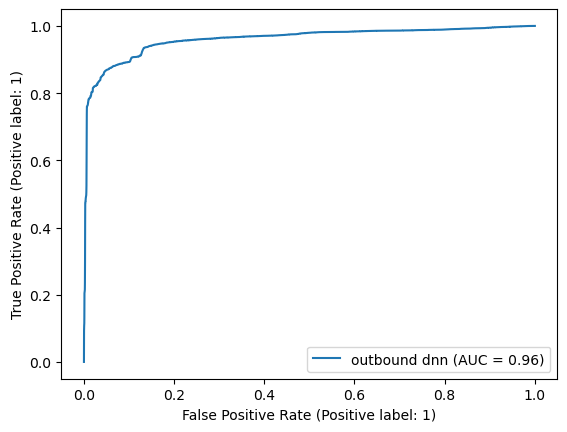

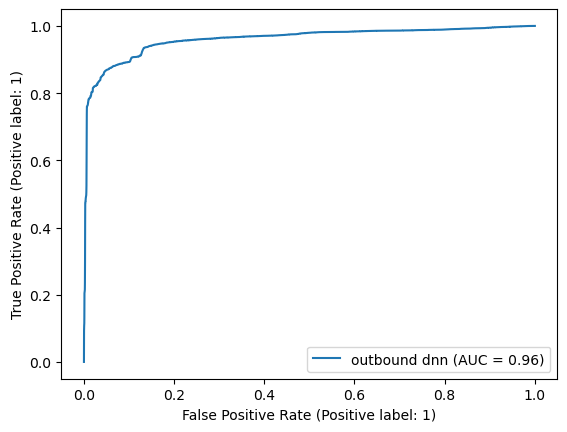

In [12]:
fpr, tpr, thresholds = roc_curve(y_val, val_positives)
roc_auc = auc(fpr, tpr)
display = RocCurveDisplay.from_predictions(y_val, val_positives, name=str(DIRECTION+' dnn'))

display.plot()

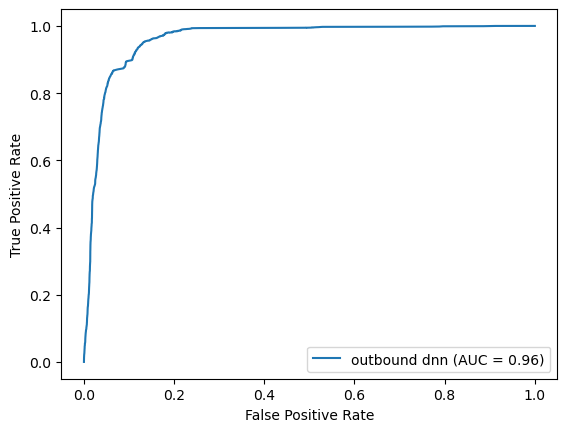

In [13]:
fpr, tpr, thresholds = roc_curve(y_val_neg, val_negatives)
roc_auc = auc(fpr, tpr)
display = RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc, estimator_name=str(DIRECTION+' dnn'))

display.plot()

In [14]:
geometric_means = np.sqrt(tpr * (1-fpr))
index = np.argmax(geometric_means)
print(thresholds)

[          inf 9.9993443e-01 9.9993277e-01 ... 3.3088327e-06 3.3087949e-06
 8.9670357e-07]


In [15]:
print('Best Threshold:', thresholds[index])
opt_thresh = thresholds[index]

Best Threshold: 0.8903637


In [16]:
yhat_test = model.predict(x_test)
y_pred_test = np.argmax(yhat_test, axis=1)

112062/112062 [==============================] - 123s 1ms/step


Original model with threshold 0.5

In [17]:
print(classification_report(y_test, y_pred_test, digits=4))

              precision    recall  f1-score   support

         0.0     0.9974    0.9921    0.9948   3496914
         1.0     0.7436    0.9000    0.8143     89048

    accuracy                         0.9898   3585962
   macro avg     0.8705    0.9460    0.9045   3585962
weighted avg     0.9911    0.9898    0.9903   3585962



In [18]:
test_positives = yhat_test[:,1]

Using ROC-derived threshold

In [19]:
y_pred = np.where(test_positives > opt_thresh, 1, 0)
print(classification_report(y_test, y_pred, digits=4))

              precision    recall  f1-score   support

         0.0     0.9773    0.9997    0.9884   3496914
         1.0     0.8684    0.0894    0.1622     89048

    accuracy                         0.9771   3585962
   macro avg     0.9229    0.5446    0.5753   3585962
weighted avg     0.9746    0.9771    0.9679   3585962



# DNN PRC Threshold

In [52]:
opt_thresh_prc = find_prc_threshold(y_val, val_positives)

print('Best PRC threshold:', opt_thresh_prc)

Best PRC threshold: 0.7503859


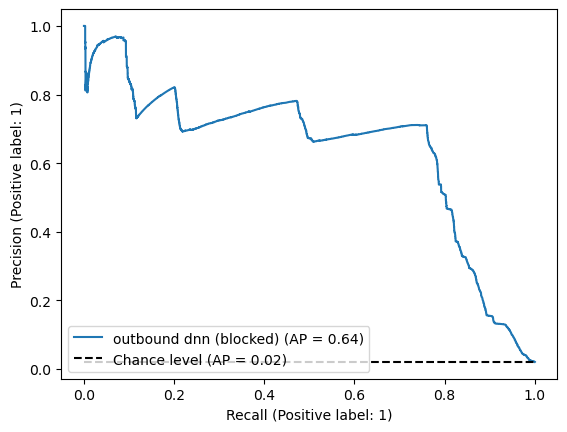

In [23]:
from sklearn.metrics import PrecisionRecallDisplay

prc_display = PrecisionRecallDisplay.from_predictions(y_val, val_positives, name=str(DIRECTION+' dnn (blocked)'), plot_chance_level=True)

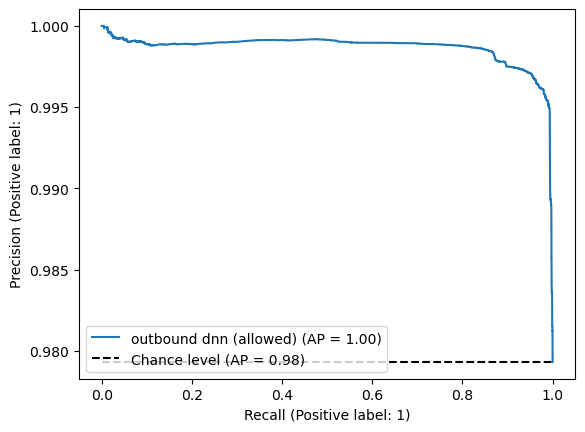

In [24]:
prc_display_n = PrecisionRecallDisplay.from_predictions(y_val_neg, val_negatives, name=str(DIRECTION+' dnn (allowed)'), plot_chance_level=True)

In [25]:
y_pred = np.where(test_positives > opt_thresh_prc, 1, 0)
print(classification_report(y_test, y_pred, digits=4))

              precision    recall  f1-score   support

         0.0     0.9773    0.9996    0.9884   3496914
         1.0     0.8653    0.0897    0.1625     89048

    accuracy                         0.9770   3585962
   macro avg     0.9213    0.5447    0.5754   3585962
weighted avg     0.9746    0.9770    0.9679   3585962



# Concrete Dropout PRC and ROC

In [29]:
CD_TEST_PRED = '/smallwork/alexander.huang/concrete_dropout/outbound/49114892/predictions.npy'
MCD_TEST_PRED = '/smallwork/alexander.huang/mcdropout/outbound/49114307/predictions.npy'

In [34]:
# loading model and data
CD_MODEL_PATH = '/smallwork/alexander.huang/models/2023-10-19/49114380_outbound_cdnn_run_2023-10-19 12:54:16.460900/checkpoint100-0.06.h5'
CD_PARAMS_PATH = '/smallwork/alexander.huang/models/2023-10-19/49114380_outbound_cdnn_run_2023-10-19 12:54:16.460900/params.yml'

# load dnn model params
with open(CD_PARAMS_PATH) as file:
    params = yaml.load(file, Loader=yaml.loader.FullLoader)

# init dnn model with params
model = M.get_cdnn_model(params)

# load dnn model weights
model.load_weights(CD_MODEL_PATH)

print(model.summary())

Model: "concrete_dropout_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 250)]             0         
                                                                 
 hidden_1 (Dense)            (None, 512)               128512    
                                                                 
 hidden_1_drop (ConcreteDen  (None, 512)               262657    
 seDropout)                                                      
                                                                 
 hidden_2_drop (ConcreteDen  (None, 2)                 1027      
 seDropout)                                                      
                                                                 
Total params: 392196 (1.50 MB)
Trainable params: 392196 (1.50 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None


In [35]:
cd_test_pred = np.load(CD_TEST_PRED)

In [37]:
cd_pred_test = np.mean(cd_test_pred, axis=0)
print(cd_pred_test.shape)

(3585962,)


In [43]:
cd_val_pred = np.stack([model.predict(x_val, verbose=2) for _ in tqdm(range(20))])


  0%|                                                                                            | 0/20 [00:00<?, ?it/s]

42473/42473 - 49s - 49s/epoch - 1ms/step



  5%|████▏                                                                               | 1/20 [01:04<20:28, 64.66s/it]

42473/42473 - 49s - 49s/epoch - 1ms/step



 10%|████████▍                                                                           | 2/20 [02:08<19:18, 64.37s/it]

42473/42473 - 50s - 50s/epoch - 1ms/step



 15%|████████████▌                                                                       | 3/20 [03:13<18:19, 64.66s/it]

42473/42473 - 49s - 49s/epoch - 1ms/step



 20%|████████████████▊                                                                   | 4/20 [04:18<17:11, 64.50s/it]

42473/42473 - 49s - 49s/epoch - 1ms/step



 25%|█████████████████████                                                               | 5/20 [05:22<16:07, 64.49s/it]

42473/42473 - 49s - 49s/epoch - 1ms/step



 30%|█████████████████████████▏                                                          | 6/20 [06:27<15:02, 64.50s/it]

42473/42473 - 49s - 49s/epoch - 1ms/step



 35%|█████████████████████████████▍                                                      | 7/20 [07:31<13:57, 64.40s/it]

42473/42473 - 49s - 49s/epoch - 1ms/step



 40%|█████████████████████████████████▌                                                  | 8/20 [08:35<12:52, 64.35s/it]

42473/42473 - 49s - 49s/epoch - 1ms/step



 45%|█████████████████████████████████████▊                                              | 9/20 [09:39<11:47, 64.30s/it]

42473/42473 - 49s - 49s/epoch - 1ms/step



 50%|█████████████████████████████████████████▌                                         | 10/20 [10:43<10:42, 64.25s/it]

42473/42473 - 49s - 49s/epoch - 1ms/step



 55%|█████████████████████████████████████████████▋                                     | 11/20 [11:47<09:37, 64.17s/it]

42473/42473 - 49s - 49s/epoch - 1ms/step



 60%|█████████████████████████████████████████████████▊                                 | 12/20 [12:52<08:34, 64.29s/it]

42473/42473 - 49s - 49s/epoch - 1ms/step



 65%|█████████████████████████████████████████████████████▉                             | 13/20 [13:56<07:29, 64.25s/it]

42473/42473 - 49s - 49s/epoch - 1ms/step



 70%|██████████████████████████████████████████████████████████                         | 14/20 [15:01<06:26, 64.36s/it]

42473/42473 - 49s - 49s/epoch - 1ms/step



 75%|██████████████████████████████████████████████████████████████▎                    | 15/20 [16:05<05:21, 64.32s/it]

42473/42473 - 49s - 49s/epoch - 1ms/step



 80%|██████████████████████████████████████████████████████████████████▍                | 16/20 [17:09<04:17, 64.35s/it]

42473/42473 - 49s - 49s/epoch - 1ms/step



 85%|██████████████████████████████████████████████████████████████████████▌            | 17/20 [18:14<03:12, 64.32s/it]

42473/42473 - 49s - 49s/epoch - 1ms/step



 90%|██████████████████████████████████████████████████████████████████████████▋        | 18/20 [19:18<02:08, 64.34s/it]

42473/42473 - 49s - 49s/epoch - 1ms/step



 95%|██████████████████████████████████████████████████████████████████████████████▊    | 19/20 [20:22<01:04, 64.20s/it]

42473/42473 - 49s - 49s/epoch - 1ms/step



100%|███████████████████████████████████████████████████████████████████████████████████| 20/20 [21:26<00:00, 64.34s/it]


In [44]:
cd_pred_val = np.mean(cd_val_pred, axis=0)

In [45]:
val_positives = cd_pred_val[:,1]
test_positives = cd_pred_test[:,1]

In [58]:
opt_thresh_prc = find_prc_threshold(y_val, val_positives)

print('Best PRC threshold:', opt_thresh_prc)

0.7321942199698671
0.7503859
Best PRC threshold: 0.7503859


In [48]:
cd_prc_test = np.where(test_positives > opt_thresh_prc, 1, 0)
print(classification_report(y_test, cd_prc_test, digits=4))

              precision    recall  f1-score   support

         0.0     0.9773    0.9996    0.9884   3496914
         1.0     0.8646    0.0897    0.1625     89048

    accuracy                         0.9770   3585962
   macro avg     0.9210    0.5447    0.5754   3585962
weighted avg     0.9745    0.9770    0.9679   3585962



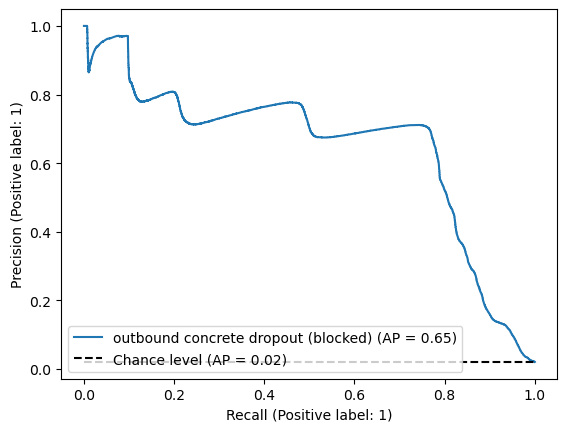

In [50]:
prc_display = PrecisionRecallDisplay.from_predictions(y_val, val_positives, name=str(DIRECTION+' concrete dropout (blocked)'), plot_chance_level=True)

# MC Dropout

In [ ]:
mc_pred = np.load(MCD_MODEL_PATH)
print(mc_pred.shape)

In [ ]:
y_pred_mcd = np.mean(mc_pred, axis=0)
print(y_pred_mcd.shape)

In [ ]:
mcd_pos = y_pred_mcd[:, 1]

In [ ]:
thresh = find_prc_threshold(y_test, mcd_pos)

In [ ]:
print('MCD Best Threshold:', thresh)

In [ ]:
y_pred = np.where(mcd_pos > thresh, 1, 0)
print(classification_report(y_test, y_pred, digits=4))

In [ ]:
prc_display = PrecisionRecallDisplay.from_predictions(y_test, mcd_pos, name=str(DIRECTION+' Monte Carlo dropout (blocked)'), plot_chance_level=True)

# Inbound Data

In [ ]:
# load data
_, _, _, _, x_test, y_test = load_data('inbound')

In [ ]:
imcd_path = '/smallwork/alexander.huang/mcdropout/inbound/49120851/predictions.npy'
icd_path = '/smallwork/alexander.huang/concrete_dropout/inbound/49164662/predictions.npy'

# Load saved predictions
imcd_pred = np.load(imcd_path)
icd_pred = np.load(icd_path)

In [ ]:
# predictions
imcd_yhat = np.mean(imcd_pred, axis=0)
icd_yhat = np.mean(icd_pred, axis=0)

print(imcd_yhat.shape)
print(icd_yhat.shape)

In [ ]:
imcd_positives = imcd_yhat[:,1]
icd_positives = icd_yhat[:,1]

In [ ]:
precision, recall, prc_thresholds = precision_recall_curve(y_test, imcd_positives)
f1score_matrix = (2*precision*recall)/(precision+recall)
prc_index = np.argmax(f1score_matrix)
mcd_thresh = prc_thresholds[prc_index]

print('Best PRC threshold:', mcd_thresh)

In [ ]:
y_pred = np.where(imcd_positives > mcd_thresh, 1, 0)
print(classification_report(y_test, y_pred, digits=4))

In [ ]:
prc_display = PrecisionRecallDisplay.from_predictions(y_test, imcd_positives, name=str('inbound Monte Carlo dropout (blocked)'), plot_chance_level=True)

In [ ]:
precision, recall, prc_thresholds = precision_recall_curve(y_test, icd_positives)
f1score_matrix = (2*precision*recall)/(precision+recall)
prc_index = np.argmax(f1score_matrix)
cd_thresh = prc_thresholds[prc_index]

print('Best PRC threshold:', cd_thresh)

In [ ]:
y_pred = np.where(imcd_positives > cd_thresh, 1, 0)
print(classification_report(y_test, y_pred, digits=4))

In [ ]:
prc_display = PrecisionRecallDisplay.from_predictions(y_test, icd_positives, name=str('inbound concrete dropout (blocked)'), plot_chance_level=True)

In [ ]:
# loading model and data
DNN_MODEL_PATH = '/smallwork/alexander.huang/models/2023-10-16/49112464_inbound_dnn_run_2023-10-16 12:58:36.901380/checkpoint100-0.14.h5'
DNN_PARAMS_PATH = '/smallwork/alexander.huang/models/2023-10-16/49112464_inbound_dnn_run_2023-10-16 12:58:36.901380/params.yml'

# load dnn model params
with open(DNN_PARAMS_PATH) as file:
    params = yaml.load(file, Loader=yaml.loader.FullLoader)

# init dnn model with params
model = M.get_dnn_model(params)

# load dnn model weights
model.load_weights(DNN_MODEL_PATH)

print(model.summary())

In [ ]:
y_proba = model.predict(x_test)

In [ ]:
positives = y_proba[:, 1]
print(positives.shape)
print(positives)

In [ ]:
opt_thresh_prc = find_prc_threshold(y_test, positives)

print('Best PRC threshold:', opt_thresh_prc)

In [ ]:
prc_display = PrecisionRecallDisplay.from_predictions(y_test, 
                                                      positives, 
                                                      name=str('inbound dnn (blocked)'), 
                                                      plot_chance_level=True)

In [ ]:
y_pred = np.where(positives > opt_thresh_prc, 1, 0)
print(classification_report(y_test, y_pred, digits=4))